# PHS 597: Homework 02

Xingyan "David" Wang

ID: 949211534

Due: March 4th, 2020

# Introduction

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL as PIL

For this homework, we are going to use a data set that refers to a dataset used for a Kaggle machine learning competition held in 2013.


Our goal is to reform some common methods, i.e. logistic regression with binary outcome or mutinomial outcome, linear regression and SVM, to neural network framework and write an algorithm to classify whether images contain either a dog or a cat. 

In [2]:
# Only run this code once to download data from website
# Later we will not run this code and directly use the path belong to load data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 27s 0us/step


In [3]:
# This path is the location where the downloaded data would be
PATH

'/Users/xingyanwang/.keras/datasets/cats_and_dogs_filtered'

In [3]:
##setting the dir of the datasets; 
PATH = '/Users/xingyanwang/.keras/datasets/cats_and_dogs_filtered'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

Then we can take a look at some examples from out training data set: 

In [4]:
#take a peek at the data; 
print(len(os.listdir(train_cats_dir)))

batch_size = 1000
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

#load images using ImageDataGenerator; 
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

1000
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


(1000, 150, 150, 3)


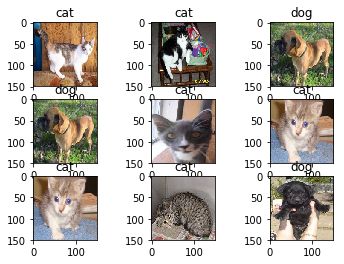

In [8]:
#show one image:
sample_training_images, sample_training_labels = next(train_data_gen)
sample_validation_images, sample_validation_labels = next(validation_data_gen)
print(sample_training_images.shape)
# (1000, 150, 150, 3) means we have 1000 images, each image is 150*150, due to colored picture, we have 3 numbers
#for each image resolution

fig, axs = plt.subplots(3,3)
cat_dog = ['cat', 'dog']
for ii in np.arange(0,3):
    for jj in np.arange(0,3):
        axs[ii,jj].imshow(sample_training_images[ii*2+jj,:,:,:])
        axs[ii,jj].title.set_text(cat_dog[int(sample_training_labels[ii*2+jj])])

Next, we would like to perform some data pre-processing. For this part, we mainly performed 2 tasks: (1) due to the original figure is colored figure instead of black and white figure (like digit recogonition project for homework 1, we will have 3 channels for each figure. Then we need to vectorize these values so that we will only have one obsevervation each row. (2) We also need to standardized for each figure in case we have extreme values that may influnce the model later. 

In [5]:
# Data preprocessing
sample_training_images, sample_training_labels = next(train_data_gen)
sample_validation_images, sample_validation_labels = next(validation_data_gen)

# Deal with training images samples
sample_training_images = sample_training_images.reshape((1000, 150 * 150 *3))
sample_training_images = sample_training_images.astype('float32') / 255

# Deal with validation images samples
sample_validation_images = sample_validation_images.reshape((1000, 150 * 150 *3))
sample_validation_images = sample_validation_images.astype('float32') / 255


In [6]:
print(sample_training_images.shape)
print(sample_validation_images.shape)

(1000, 67500)
(1000, 67500)


Notice that, instead of having dimension of 1000*150*150*3, we only have 1000*67500. In another word, previously, we need to use a 3-D matrix for each figure, but for now we only need to use a matrix to store all information with each row as one figure. 

Next, since our outcome is either "cat" or "dog", a binary (or categorical) variable, then we need to categorize the outcome variables in both training data set and validation data set:

In [7]:
from keras.utils import to_categorical
sample_training_labels = to_categorical(sample_training_labels)
sample_validation_labels = to_categorical(sample_validation_labels)

print(sample_training_labels.shape)
print(sample_validation_labels.shape)

(1000, 2)
(1000, 2)


Using TensorFlow backend.


The reason that why after categorization, the binary outcome becomes vector of 2 is that they use one-hot encoding so that each outcome is either (0, 1) or (1, 0). Let's take a look at the more carefully: 

In [8]:
print(sample_training_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


Notice that we use 2 values to represent the label in this dataset. 

In [9]:
print(sample_training_images)

[[0.00092272 0.00099962 0.00090734 ... 0.00275279 0.00269127 0.00252211]
 [0.00058439 0.00104575 0.0002153  ... 0.00178393 0.00239908 0.00107651]
 [0.00096886 0.00121492 0.00104575 ... 0.00356786 0.00356786 0.00356786]
 ...
 [0.00298347 0.00232218 0.00221453 ... 0.00089196 0.00090734 0.00096886]
 [0.0004306  0.00035371 0.00030757 ... 0.00153787 0.0012303  0.00106113]
 [0.00227605 0.00181469 0.00141484 ... 0.00299885 0.00262976 0.00226067]]


For sample trainings, each row represents one sample/image, while, each column is one feature of the this sample/image. 

In [10]:
# create backup data set so that: 
#1. initilaize data set for each methods;
#2. in case something wrong later.

sample_training_images_bp = sample_training_images
sample_validation_images_bp = sample_validation_images

sample_training_labels_bp = sample_training_labels
sample_validation_labels_bp = sample_validation_labels 

#  Logistic Regression with Binary Outcome

For the first model, we would like to take a look at logistic regression with binary outcome. First, we would like to define the features of the model: 

In [11]:
# There are 67,500 features here, A's dimension is (67500, 1)
A = tf.Variable(tf.random_normal(shape=[67500, 1]))
# Intercept
b = tf.Variable(tf.random_normal(shape=[1, 1]))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
print(A)
print(b)

<tf.Variable 'Variable:0' shape=(67500, 1) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(1, 1) dtype=float32_ref>


Notice that we defined 2 variables here A and b. These two variables are defined for each figure, A has a dimension of 67500 beacuse we have 67500 covariates that would help us to learn. b has a dimension of 1, because we only will include a single intercept in the model. 

Next, we would like to define an initializer for the model: 

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Define two placeholders, one for our input variables, the other is for outcome variables

In [14]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 67500])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

Notice here, for our target, we only define a dimension of 1 instead of 2. This is because previously, we already see that if we use one hot encoding, one column of outcome variable is nuisance. 

In [15]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b

Next, we would like to define a loss function for the model that we would like to learn.

In [16]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

Then, we need to define the some parameters that can be used in deep learning, including learning rate, batch size and number of iterations:

In [17]:
# Define the learning rate， batch_size etc.
learning_rate = 0.3
batch_size = 128
iter_num = 3000

We use gradient descent approach to perform the optimization: 

In [18]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

Define the optimization goal for this question, which is minimize loss function: 

In [19]:
# Define the goal
goal = opt.minimize(loss)

Then we can define the test accuracy for this model that we would like to fit: 

In [20]:
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)


After we define all these framework for our model, then we can feed in data so that we can start to fit the model. We use three variables to store the model results, including loss_trace to keep track of the loss; train_acc to store the track of training data accuracy; test_acc to store the track of test data accuracy. 

In [21]:

# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

Before we run the whole analysis, we can take a look at what each epoch do. This is only for myself learning and understanding procedure. 

In [22]:
epoch = 1
# sample batch_size of samples for each epoch
batch_index = np.random.choice(len(sample_training_images), size=batch_size)
batch_train_X = sample_training_images[batch_index]
batch_train_y = np.matrix(sample_training_labels[batch_index]).T
batch_train_y = np.transpose(batch_train_y[1])

In [23]:
# run analysis
sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})

In [24]:
# caluclate loss
temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
# use the WHOLE training data set to calculate training data set accuracy
temp_train_acc = sess.run(accuracy, feed_dict={data: batch_train_X, target: np.matrix(batch_train_y)})

# calulate test data set accuracy
test_X = sample_validation_images 
test_y = np.matrix(sample_validation_labels).T
test_y = np.transpose(test_y[1])
temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: test_y})

print(temp_loss )
print(temp_train_acc)
print(temp_test_acc)

0.7423452
0.515625
0.479


Now, we can use a for loop on number of iteration that we would like to perform to do this analysis: 

In [40]:
# training model

# sample_training_images, sample_training_labels,
for epoch in range(iter_num):
    # Generate random batch index and use the part of training samples to train models
    batch_index = np.random.choice(len(sample_training_images), size=batch_size)
    batch_train_X = sample_training_images[batch_index]
    batch_train_y = np.matrix(sample_training_labels[batch_index]).T
    batch_train_y = np.transpose(batch_train_y[1])
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    
    # use the whole training data to evaluate the performance of the model
    train_X = sample_training_images 
    train_y = np.matrix(sample_training_labels).T
    train_y = np.transpose(train_y[1])
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y)})
    
    # use the test data to evaluate the performance of the model
    test_X = sample_validation_images 
    test_y = np.matrix(sample_validation_labels).T
    test_y = np.transpose(test_y[1])
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target:  np.matrix(test_y)})
    
    
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 200 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  200 loss: 0.682103 train_acc: 0.539000 test_acc: 0.534000
epoch:  400 loss: 0.696430 train_acc: 0.533000 test_acc: 0.528000
epoch:  600 loss: 0.686328 train_acc: 0.544000 test_acc: 0.538000
epoch:  800 loss: 0.687379 train_acc: 0.548000 test_acc: 0.539000
epoch: 1000 loss: 0.677688 train_acc: 0.554000 test_acc: 0.552000
epoch: 1200 loss: 0.671036 train_acc: 0.559000 test_acc: 0.553000
epoch: 1400 loss: 0.689300 train_acc: 0.553000 test_acc: 0.545000
epoch: 1600 loss: 0.674455 train_acc: 0.561000 test_acc: 0.555000
epoch: 1800 loss: 0.685058 train_acc: 0.566000 test_acc: 0.552000
epoch: 2000 loss: 0.683473 train_acc: 0.570000 test_acc: 0.560000
epoch: 2200 loss: 0.674184 train_acc: 0.578000 test_acc: 0.564000
epoch: 2400 loss: 0.669004 train_acc: 0.575000 test_acc: 0.548000
epoch: 2600 loss: 0.675853 train_acc: 0.580000 test_acc: 0.569000
epoch: 2800 loss: 0.662910 train_acc: 0.574000 test_acc: 0.566000
epoch: 3000 loss: 0.682150 train_acc: 0.589000 test_acc: 0.563000


Then we can visualize the result: first, we can take a look at the trace of loss function: 

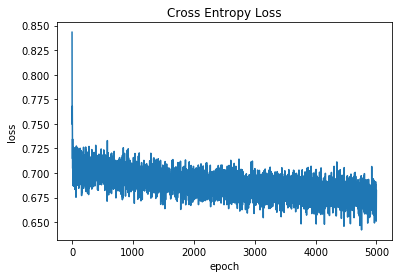

In [41]:
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

From the plot, we can see that overall, loss has a decreasing trend from over 0.825 to around 0.700. However, as the number of epoch increases, the loss is still bounced a lot around 0.675 to 0.725. 

Next, we would like to see the training accruacy (use the whole training data set) and test accuracy. 

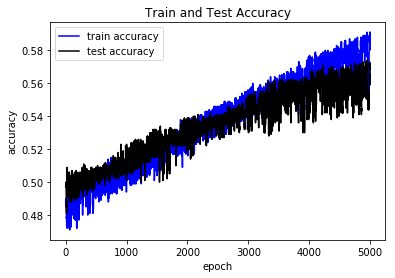

In [42]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

From the plot, we can see that the accuracy for training and test data set has an increasing overall trend. This is because when we train the model, we did not use the whole sample for training set. We only used a subset of samples. So, it will not encounter over-fitting issue. However, (1) These two accuarcies are still bounced around from epoch to epoch; (2) The training accuracy will increase more than than the test accuracy. This is because we are using part of the sample from training data set and also include this part in the prediction part. In that case, it will some kind increse the accuracy of the training data due to "prefect predicition". 

Next, we would like to see the influnce of parameters. In this example, we have 3 parameters: learning_rate stands for learning rate, batch_size stands for batch size, iter_num stands for number of iterations that we would like to fit. For this question, we would like to see the influence of learning rate parameters. Other parameters will be examined similarly in other methods. First, we would like to set up our parameters: 

In [26]:
learning_rate = range(1, 11, 1)
batch_size = 128
iter_num = 3000

In [27]:
for x, l_rate in enumerate(learning_rate):
    print(l_rate/10)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [28]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# Define the variable that stores the result
loss_trace_min = []
loss_trace_max = []
train_acc_min = []
train_acc_max = []
test_acc_min = []
test_acc_max = []

# sample_training_images, sample_training_labels

for x,l_rate in enumerate(learning_rate):
    loss_trance = []
    train_acc = []
    test_acc = []
    opt = tf.train.GradientDescentOptimizer(l_rate/10)
    for epoch in range(iter_num):
          # Generate random batch index and use the part of training samples to train models
          batch_index = np.random.choice(len(sample_training_images), size = batch_size )
          batch_train_X = sample_training_images[batch_index]
          batch_train_y = np.matrix(sample_training_labels[batch_index]).T
          batch_train_y = np.transpose(batch_train_y[1])
          sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
          temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    
          # use the whole training data to evaluate the performance of the model
          train_X = sample_training_images 
          train_y = np.matrix(sample_training_labels).T
          train_y = np.transpose(train_y[1])
          temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y)})
    
          # use the test data to evaluate the performance of the model
          test_X = sample_validation_images 
          test_y = np.matrix(sample_validation_labels).T
          test_y = np.transpose(test_y[1])
          temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target:  np.matrix(test_y)})
    
    
          # recode the result
          loss_trace.append(temp_loss)
          train_acc.append(temp_train_acc)
          test_acc.append(temp_test_acc)
          # output
          if (epoch + 1) % 200 == 0:
                print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                                  temp_train_acc, temp_test_acc))
    print(l_rate/10)
    loss_trace_min.append(min(loss_trace))
    loss_trace_max.append(max(loss_trace))
    train_acc_min.append(min(train_acc))
    train_acc_max.append(max(train_acc))
    test_acc_min.append(min(test_acc))
    test_acc_max.append(max(test_acc))

epoch:  200 loss: 0.706461 train_acc: 0.500000 test_acc: 0.511000
epoch:  400 loss: 0.690141 train_acc: 0.514000 test_acc: 0.515000
epoch:  600 loss: 0.680087 train_acc: 0.515000 test_acc: 0.507000
epoch:  800 loss: 0.672862 train_acc: 0.542000 test_acc: 0.529000
epoch: 1000 loss: 0.699680 train_acc: 0.548000 test_acc: 0.520000
epoch: 1200 loss: 0.689798 train_acc: 0.558000 test_acc: 0.529000
epoch: 1400 loss: 0.687996 train_acc: 0.552000 test_acc: 0.536000
epoch: 1600 loss: 0.663695 train_acc: 0.565000 test_acc: 0.530000
epoch: 1800 loss: 0.659107 train_acc: 0.554000 test_acc: 0.537000
epoch: 2000 loss: 0.672553 train_acc: 0.560000 test_acc: 0.545000
epoch: 2200 loss: 0.681314 train_acc: 0.568000 test_acc: 0.543000
epoch: 2400 loss: 0.697526 train_acc: 0.570000 test_acc: 0.534000
epoch: 2600 loss: 0.676049 train_acc: 0.583000 test_acc: 0.539000
epoch: 2800 loss: 0.666046 train_acc: 0.569000 test_acc: 0.559000
epoch: 3000 loss: 0.666244 train_acc: 0.584000 test_acc: 0.550000
0.1
epoch:

epoch: 1000 loss: 0.610789 train_acc: 0.674000 test_acc: 0.599000
epoch: 1200 loss: 0.611511 train_acc: 0.679000 test_acc: 0.615000
epoch: 1400 loss: 0.609637 train_acc: 0.674000 test_acc: 0.609000
epoch: 1600 loss: 0.607001 train_acc: 0.671000 test_acc: 0.606000
epoch: 1800 loss: 0.594082 train_acc: 0.676000 test_acc: 0.602000
epoch: 2000 loss: 0.603146 train_acc: 0.676000 test_acc: 0.603000
epoch: 2200 loss: 0.635064 train_acc: 0.670000 test_acc: 0.594000
epoch: 2400 loss: 0.607114 train_acc: 0.677000 test_acc: 0.602000
epoch: 2600 loss: 0.635918 train_acc: 0.679000 test_acc: 0.604000
epoch: 2800 loss: 0.623591 train_acc: 0.679000 test_acc: 0.605000
epoch: 3000 loss: 0.619071 train_acc: 0.684000 test_acc: 0.605000
0.9
epoch:  200 loss: 0.608165 train_acc: 0.680000 test_acc: 0.606000
epoch:  400 loss: 0.607298 train_acc: 0.682000 test_acc: 0.607000
epoch:  600 loss: 0.622370 train_acc: 0.675000 test_acc: 0.614000
epoch:  800 loss: 0.609047 train_acc: 0.679000 test_acc: 0.610000
epoch:

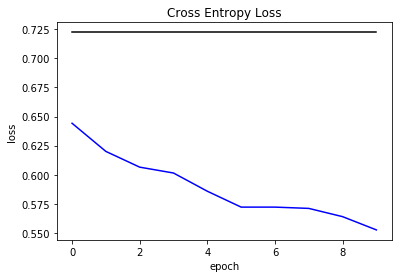

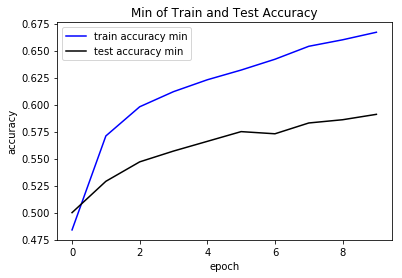

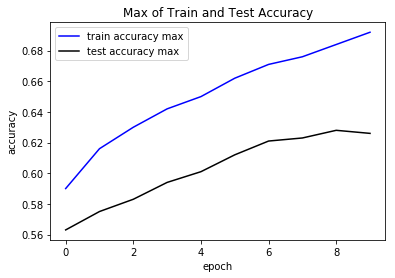

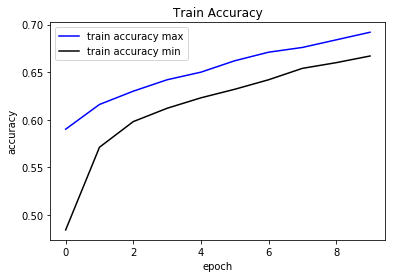

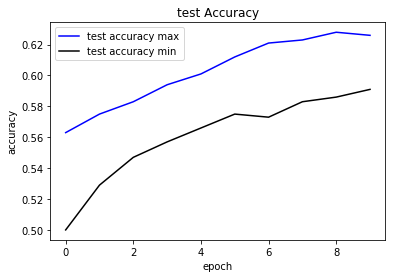

In [29]:
# loss function
plt.plot(loss_trace_min,'b-')
plt.plot(loss_trace_max, 'k-')
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# accuracy min
plt.plot(train_acc_min, 'b-', label='train accuracy min')
plt.plot(test_acc_min, 'k-', label='test accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Min of Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# accuracy max
plt.plot(train_acc_max, 'b-', label='train accuracy max')
plt.plot(test_acc_max, 'k-', label='test accuracy max')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Max of Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# accuracy for train
plt.plot(train_acc_max, 'b-', label='train accuracy max')
plt.plot(train_acc_min, 'k-', label='train accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy')
plt.legend(loc='best')
plt.show()


# accuracy for test
plt.plot(test_acc_max, 'b-', label='test accuracy max')
plt.plot(test_acc_min, 'k-', label='test accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('test Accuracy')
plt.legend(loc='best')
plt.show()

In [30]:
print(train_acc_min)
print(train_acc_max)
print(test_acc_min)
print(test_acc_max)

[0.484, 0.571, 0.598, 0.612, 0.623, 0.632, 0.642, 0.654, 0.66, 0.667]
[0.59, 0.616, 0.63, 0.642, 0.65, 0.662, 0.671, 0.676, 0.684, 0.692]
[0.5, 0.529, 0.547, 0.557, 0.566, 0.575, 0.573, 0.583, 0.586, 0.591]
[0.563, 0.575, 0.583, 0.594, 0.601, 0.612, 0.621, 0.623, 0.628, 0.626]


Notice that for this question, when the number of iteration is fixed, the larger of learning rate, the better of the predictions. However, this may not be true if we increase the number of iterations. 

# Logistic Regression with Multinomial Outcome

For logitic regression with multinomial outcome, the difference from logistic regression with binary outcome is the dimension of the outcome variable. If we have binary outcome, then we can use 1 single variable to represent. However, if we have 3 levels, then we need 2 variables.  We can have the following programming: 

In [45]:
# Initialize data set: 
sample_training_images = sample_training_images_bp
sample_validation_images = sample_validation_images_bp

sample_training_labels = sample_training_labels_bp
sample_validation_labels = sample_validation_labels_bp 

We use m here to indicate number of new variables that we need to construct for outcome, m = number of catgeory-1. In this case, we have 2 categories, ie dog or cat. Then we only need 1 variable, so m = 1. 

In [46]:
# Define model framework
m = 1
A = tf.Variable(tf.random_normal(shape=[67500, 1]))
b = tf.Variable(tf.random_normal(shape=[1, m]))

In order to not be so boring of coding, we would like to use a different 

In [47]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 67500])
target = tf.placeholder(dtype=tf.float32, shape=[None, m])

# Declare the model you need to learn
mod = tf.matmul(data, A) + b

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Define the parameters
learning_rate = 0.3
batch_size = 128
iter_num = 3000

# Define loss function
loss  = tf.reduce_sum(tf.pow(mod-target, 2))/(2*batch_size)

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Define the goal
goal = opt.minimize(loss)

I am not going to examine futher for this part, since it will be equivalent to logistic regression with binary outcome. 

# Linear Regression

As for linear regression, there are 2 main differences with logistic regression: link function and loss function. Similar to logistic regression, we would like to perform linear regression: 

In [12]:
# Initialize data set: 
sample_training_images = sample_training_images_bp
sample_validation_images = sample_validation_images_bp

sample_training_labels = sample_training_labels_bp
sample_validation_labels = sample_validation_labels_bp 

In [15]:
# Define model framework

A = tf.Variable(tf.random_normal(shape=[67500, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 67500])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Declare the model you need to learn
mod = tf.matmul(data, A) + b

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Define the parameters
learning_rate = 0.3
batch_size = 128
iter_num = 3000

# Define loss function
loss  = tf.reduce_sum(tf.pow(mod-target, 2))/(2*batch_size)

# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

# Define optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Define the goal
goal = opt.minimize(loss)

One trick part here for this question is that, our outcome variable is a binary outcome. For linear regression, we will predicition of continuous outcome. One possible technique that I can think of is to "round" data to 0 or 1. To be more precise, if our prediction is >= 0.5 then, we will categoirze as 1, otherwise we will categorize as 0. This is ONLY SPECIFIC for this problem, 

In [16]:
# Define prediction accuracy
prediction = tf.cast(mod>=0.5, dtype = tf.float32)
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)

Then we can start to fit the model: 

In [17]:
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

# sample_training_images, sample_training_labels,
for epoch in range(iter_num):
    # Generate random batch index and use the part of training samples to train models
    batch_index = np.random.choice(len(sample_training_images), size=batch_size)
    batch_train_X = sample_training_images[batch_index]
    batch_train_y = np.matrix(sample_training_labels[batch_index]).T
    batch_train_y = np.transpose(batch_train_y[1])
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    
    # use the whole training data to evaluate the performance of the model
    train_X = sample_training_images 
    train_y = np.matrix(sample_training_labels).T
    train_y = np.transpose(train_y[1])
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y)})
    
    # use the test data to evaluate the performance of the model
    test_X = sample_validation_images 
    test_y = np.matrix(sample_validation_labels).T
    test_y = np.transpose(test_y[1])
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target:  np.matrix(test_y)})
    
    
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 200 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  200 loss: 0.142641 train_acc: 0.501000 test_acc: 0.501000
epoch:  400 loss: 0.135119 train_acc: 0.500000 test_acc: 0.497000
epoch:  600 loss: 0.132816 train_acc: 0.513000 test_acc: 0.510000
epoch:  800 loss: 0.137709 train_acc: 0.521000 test_acc: 0.517000
epoch: 1000 loss: 0.131628 train_acc: 0.521000 test_acc: 0.526000
epoch: 1200 loss: 0.139028 train_acc: 0.524000 test_acc: 0.519000
epoch: 1400 loss: 0.134526 train_acc: 0.533000 test_acc: 0.528000
epoch: 1600 loss: 0.128625 train_acc: 0.546000 test_acc: 0.536000
epoch: 1800 loss: 0.120322 train_acc: 0.540000 test_acc: 0.532000
epoch: 2000 loss: 0.139220 train_acc: 0.562000 test_acc: 0.546000
epoch: 2200 loss: 0.120621 train_acc: 0.579000 test_acc: 0.551000
epoch: 2400 loss: 0.118182 train_acc: 0.566000 test_acc: 0.551000
epoch: 2600 loss: 0.123994 train_acc: 0.586000 test_acc: 0.554000
epoch: 2800 loss: 0.123351 train_acc: 0.567000 test_acc: 0.548000
epoch: 3000 loss: 0.116418 train_acc: 0.584000 test_acc: 0.555000


Then we can still plot loss function traces, training data set accuracy and test data set accuracy. 

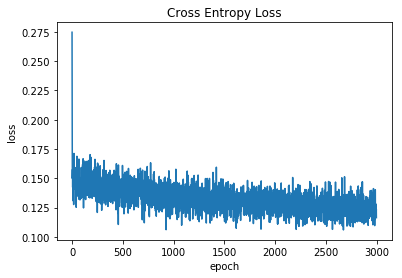

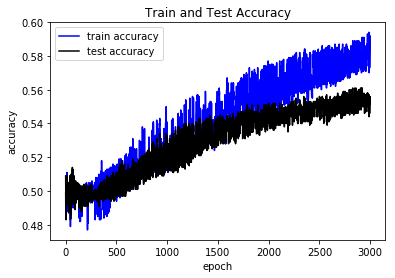

In [18]:
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

In [19]:
print(min(train_acc))
print(max(train_acc))

print(min(test_acc))
print(max(test_acc))

0.477
0.594
0.483
0.561


Additionally, we would like to see the influence of some parameters. In this case, we mainly have 3 parameters: learning rate (learning_rate), batch size (batch_size) and number of iteration (iter_num). For this part, we would like to see the influence of batch size. Because we only have 1000 samples in the training data set, we will examine the batch size from 100 to 1000, increase by 100 each time. 

In [28]:
learning_rate = 0.3
batch_size = range(100, 601, 100)
iter_num = 3000

In [29]:
print(batch_size)

range(100, 601, 100)


In [30]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# Define the variable that stores the result
loss_trace_min = []
loss_trace_max = []
train_acc_min = []
train_acc_max = []
test_acc_min = []
test_acc_max = []

# sample_training_images, sample_training_labels

for x,c_range in enumerate(batch_size):
    loss_trance = []
    train_acc = []
    test_acc = []
    for epoch in range(iter_num):
          # Generate random batch index and use the part of training samples to train models
          batch_index = np.random.choice(len(sample_training_images), size = c_range)
          batch_train_X = sample_training_images[batch_index]
          batch_train_y = np.matrix(sample_training_labels[batch_index]).T
          batch_train_y = np.transpose(batch_train_y[1])
          sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
          temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    
          # use the whole training data to evaluate the performance of the model
          train_X = sample_training_images 
          train_y = np.matrix(sample_training_labels).T
          train_y = np.transpose(train_y[1])
          temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y)})
    
          # use the test data to evaluate the performance of the model
          test_X = sample_validation_images 
          test_y = np.matrix(sample_validation_labels).T
          test_y = np.transpose(test_y[1])
          temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target:  np.matrix(test_y)})
    
    
          # recode the result
          loss_trace.append(temp_loss)
          train_acc.append(temp_train_acc)
          test_acc.append(temp_test_acc)
          # output
          if (epoch + 1) % 200 == 0:
                print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                                  temp_train_acc, temp_test_acc))
    print(c_range)
    loss_trace_min.append(min(loss_trace))
    loss_trace_max.append(max(loss_trace))
    train_acc_min.append(min(train_acc))
    train_acc_max.append(max(train_acc))
    test_acc_min.append(min(test_acc))
    test_acc_max.append(max(test_acc))

epoch:  200 loss: 0.130784 train_acc: 0.513000 test_acc: 0.493000
epoch:  400 loss: 0.120229 train_acc: 0.516000 test_acc: 0.495000
epoch:  600 loss: 0.109176 train_acc: 0.524000 test_acc: 0.498000
epoch:  800 loss: 0.119908 train_acc: 0.527000 test_acc: 0.509000
epoch: 1000 loss: 0.099510 train_acc: 0.528000 test_acc: 0.500000
epoch: 1200 loss: 0.103132 train_acc: 0.523000 test_acc: 0.502000
epoch: 1400 loss: 0.099959 train_acc: 0.522000 test_acc: 0.502000
epoch: 1600 loss: 0.090774 train_acc: 0.537000 test_acc: 0.505000
epoch: 1800 loss: 0.106672 train_acc: 0.539000 test_acc: 0.507000
epoch: 2000 loss: 0.107053 train_acc: 0.535000 test_acc: 0.514000
epoch: 2200 loss: 0.116819 train_acc: 0.542000 test_acc: 0.517000
epoch: 2400 loss: 0.101402 train_acc: 0.543000 test_acc: 0.514000
epoch: 2600 loss: 0.095052 train_acc: 0.551000 test_acc: 0.512000
epoch: 2800 loss: 0.109123 train_acc: 0.550000 test_acc: 0.530000
epoch: 3000 loss: 0.103309 train_acc: 0.557000 test_acc: 0.519000
100
epoch:

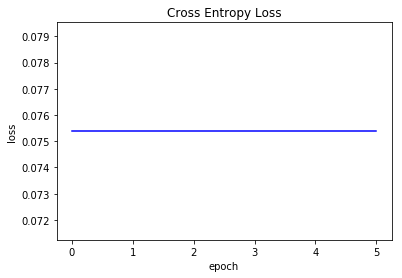

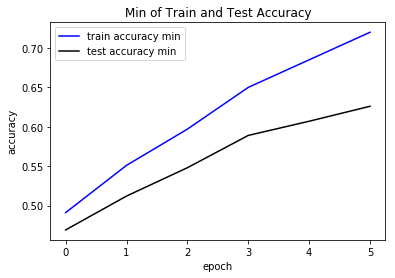

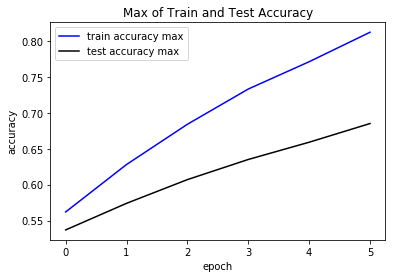

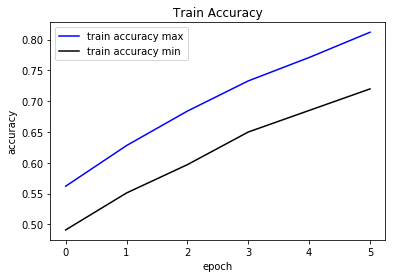

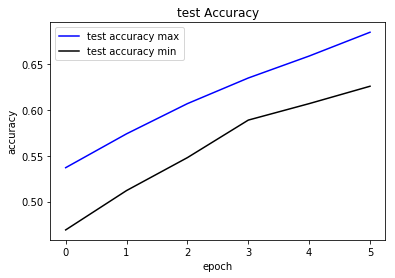

In [31]:
# loss function
plt.plot(loss_trace_min,'b-')
plt.plot(loss_trace_max, 'k-')
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# accuracy min
plt.plot(train_acc_min, 'b-', label='train accuracy min')
plt.plot(test_acc_min, 'k-', label='test accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Min of Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# accuracy max
plt.plot(train_acc_max, 'b-', label='train accuracy max')
plt.plot(test_acc_max, 'k-', label='test accuracy max')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Max of Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# accuracy for train
plt.plot(train_acc_max, 'b-', label='train accuracy max')
plt.plot(train_acc_min, 'k-', label='train accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy')
plt.legend(loc='best')
plt.show()


# accuracy for test
plt.plot(test_acc_max, 'b-', label='test accuracy max')
plt.plot(test_acc_min, 'k-', label='test accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('test Accuracy')
plt.legend(loc='best')
plt.show()

In [32]:
print(train_acc_min)
print(train_acc_max)
print(test_acc_min)
print(test_acc_max)

[0.491, 0.551, 0.597, 0.65, 0.685, 0.72]
[0.562, 0.628, 0.684, 0.733, 0.771, 0.812]
[0.469, 0.512, 0.548, 0.589, 0.607, 0.626]
[0.537, 0.574, 0.607, 0.635, 0.659, 0.685]


An interesting observation is that when number of batch size increases, accuracy for training set increases all the time while the accuracy for test set first increase then keep on a certain level. This is because batch size represents the number of samples that we will get from the data set, then when batch size increases, definitely the test and train accuracy will increase at first. When the batch size increases to a certain number, then we train accuracy will continue to increase and the test accuracy will keep on a certain level due to linear regression will not be a very good option of this classification problem. 

# Optimal Separating Hyperplanes

Next, we would like to see what will be for using tensorflow to implement optimal separating hyperplanes. Usually, for this method, people would like to use -1 and 1 instead of 0 and 1 to represents. This is beacuse for -1 and 1, we only need to observe the sign of the predicted value. If we use 0 and 1, then we can not obtain all the information by just watching the sign. 

In [71]:
# Initialize data set: 
sample_training_images = sample_training_images_bp
sample_validation_images = sample_validation_images_bp

sample_training_labels = sample_training_labels_bp
sample_validation_labels = sample_validation_labels_bp 

In [26]:
test = (sample_validation_labels==0)
print(test)

[[ True False]
 [ True False]
 [False  True]
 ...
 [ True False]
 [False  True]
 [ True False]]


In [29]:
sample_validation_labels[sample_validation_labels==0] = -1

Print the labels again to see if we achieve our goal: 

In [30]:
print(sample_validation_labels)

[[-1.  1.]
 [-1.  1.]
 [ 1. -1.]
 ...
 [-1.  1.]
 [ 1. -1.]
 [-1.  1.]]


In [31]:
# Define model framework
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

A = tf.Variable(tf.random_normal(shape=[67500, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 67500])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Declare the model you need to learn
mod = tf.matmul(data, A) + b

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Define the parameters
learning_rate = 0.3
batch_size = 128
iter_num = 3000
svmC = 0.1

Instructions for updating:
Colocations handled automatically by placer.


Notice that one difference for SVM is that we have an additional parameter, ie svmC here to measure the loss between regularization loss and hinge loss. Then we will define the loss function as follow: 

In [33]:
# Define loss function
regularization_loss = 0.5*tf.reduce_sum(tf.square(A)) 
hinge_loss = tf.reduce_sum(tf.maximum(tf.zeros([batch_size,1]), 1 - target*mod))
svm_loss = regularization_loss + svmC*hinge_loss

# Define optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

# Define the goal
goal = opt.minimize(svm_loss)

In [34]:
predicted_class = tf.sign(mod);

correct = tf.cast(tf.equal(predicted_class, target), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

In [35]:
epoch = 1
batch_index = np.random.choice(len(sample_training_images), size=batch_size)

In [36]:
batch_train_X = sample_training_images[batch_index]
batch_train_y = np.matrix(sample_training_labels[batch_index]).T
batch_train_y = np.transpose(batch_train_y[1])

In [37]:
sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})

In [38]:
temp_loss = sess.run(svm_loss, feed_dict={data: batch_train_X, target: batch_train_y})

After we defined the model, we then, can feed in data for prediction: 

In [40]:
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

# sample_training_images, sample_training_labels,
for epoch in range(iter_num):
    
    # Generate random batch index and use the part of training samples to train models
    batch_index = np.random.choice(len(sample_training_images), size=batch_size)
    batch_train_X = sample_training_images[batch_index]
    batch_train_y = np.matrix(sample_training_labels[batch_index]).T
    batch_train_y = np.transpose(batch_train_y[1])
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(svm_loss, feed_dict={data: batch_train_X, target: batch_train_y})
    
    # use the whole training data to evaluate the performance of the model
    train_X = sample_training_images 
    train_y = np.matrix(sample_training_labels).T
    train_y = np.transpose(train_y[1])
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y)})
    
    # use the test data to evaluate the performance of the model
    test_X = sample_validation_images 
    test_y = np.matrix(sample_validation_labels).T
    test_y = np.transpose(test_y[1])
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target:  np.matrix(test_y)})
    
    
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 200 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  200 loss: 5.700000 train_acc: 0.505000 test_acc: 0.512000
epoch:  400 loss: 7.000000 train_acc: 0.505000 test_acc: 0.512000
epoch:  600 loss: 5.600000 train_acc: 0.505000 test_acc: 0.512000
epoch:  800 loss: 6.300000 train_acc: 0.505000 test_acc: 0.512000
epoch: 1000 loss: 6.700000 train_acc: 0.505000 test_acc: 0.512000
epoch: 1200 loss: 7.700000 train_acc: 0.505000 test_acc: 0.512000
epoch: 1400 loss: 6.700000 train_acc: 0.505000 test_acc: 0.512000
epoch: 1600 loss: 5.700000 train_acc: 0.505000 test_acc: 0.512000
epoch: 1800 loss: 6.700000 train_acc: 0.505000 test_acc: 0.512000
epoch: 2000 loss: 6.700000 train_acc: 0.505000 test_acc: 0.512000
epoch: 2200 loss: 6.300000 train_acc: 0.505000 test_acc: 0.512000
epoch: 2400 loss: 5.200000 train_acc: 0.505000 test_acc: 0.512000
epoch: 2600 loss: 6.400000 train_acc: 0.505000 test_acc: 0.512000
epoch: 2800 loss: 6.300000 train_acc: 0.505000 test_acc: 0.512000
epoch: 3000 loss: 6.200000 train_acc: 0.505000 test_acc: 0.512000


It would be easier to use plottings to see the trend of loss and accuracy: 

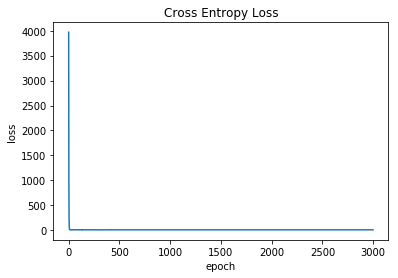

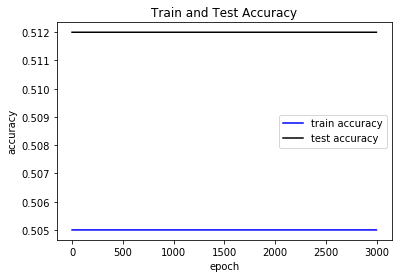

In [41]:
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

Notice that the loss function varies a lot at the begining, so it is hard to see the trend. In that case, I subset the limit to 5 to 20 so that it is easier to see the trend. 

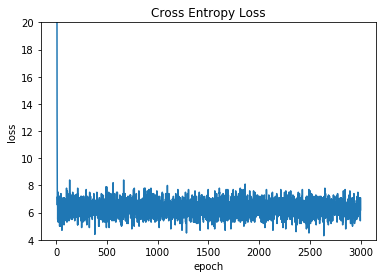

In [43]:
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(4,20)
plt.show()

In [44]:
print(max(test_acc))
print(min(test_acc))

print(max(train_acc))
print(min(train_acc))

0.512
0.512
0.505
0.505


For SVM, the parameter that we are interested in is svmC, this value measures the penalty that we put on hinge loss function. Next, we would like to see the influence of this parameter on the final results. Instead of printing out the whole process of optimization, we only look at min and max for training and test data set, aside with min and max for loss. 

In [153]:
# Define the parameters
learning_rate = 0.3
batch_size = 128
iter_num = 3000
svmC = range(1, 10)

In [154]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
# Define the variable that stores the result
loss_trace_min = []
loss_trace_max = []
train_acc_min = []
train_acc_max = []
test_acc_min = []
test_acc_max = []

# sample_training_images, sample_training_labels,
for x,c_range in enumerate(svmC):
    loss_trance = []
    train_acc = []
    test_acc = []
    svm_loss = regularization_loss + (c_range/10)*hinge_loss
    opt = tf.train.GradientDescentOptimizer(learning_rate)
    goal = opt.minimize(svm_loss)
    for epoch in range(iter_num):
          # Generate random batch index and use the part of training samples to train models
          batch_index = np.random.choice(len(sample_training_images), size=batch_size)
          batch_train_X = sample_training_images[batch_index]
          batch_train_y = np.matrix(sample_training_labels[batch_index]).T
          batch_train_y = np.transpose(batch_train_y[1])
          sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
          temp_loss = sess.run(svm_loss, feed_dict={data: batch_train_X, target: batch_train_y})
    
          # use the whole training data to evaluate the performance of the model
          train_X = sample_training_images 
          train_y = np.matrix(sample_training_labels).T
          train_y = np.transpose(train_y[1])
          temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y)})
    
          # use the test data to evaluate the performance of the model
          test_X = sample_validation_images 
          test_y = np.matrix(sample_validation_labels).T
          test_y = np.transpose(test_y[1])
          temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target:  np.matrix(test_y)})
    
    
          # recode the result
          loss_trace.append(temp_loss)
          train_acc.append(temp_train_acc)
          test_acc.append(temp_test_acc)
          # output
          if (epoch + 1) % 200 == 0:
                print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                                  temp_train_acc, temp_test_acc))
    print(c_range)
    loss_trace_min.append(min(loss_trace))
    loss_trace_max.append(max(loss_trace))
    train_acc_min.append(min(train_acc))
    train_acc_max.append(max(train_acc))
    test_acc_min.append(min(test_acc))
    test_acc_max.append(max(test_acc))

epoch:  200 loss: 11.731336 train_acc: 0.512000 test_acc: 0.503000
epoch:  400 loss: 12.680299 train_acc: 0.512000 test_acc: 0.503000
epoch:  600 loss: 12.542728 train_acc: 0.488000 test_acc: 0.497000
epoch:  800 loss: 14.027282 train_acc: 0.512000 test_acc: 0.503000
epoch: 1000 loss: 13.313505 train_acc: 0.488000 test_acc: 0.497000
epoch: 1200 loss: 14.172706 train_acc: 0.512000 test_acc: 0.503000
epoch: 1400 loss: 11.592602 train_acc: 0.488000 test_acc: 0.497000
epoch: 1600 loss: 13.040705 train_acc: 0.512000 test_acc: 0.503000
epoch: 1800 loss: 12.659134 train_acc: 0.488000 test_acc: 0.497000
epoch: 2000 loss: 13.134495 train_acc: 0.512000 test_acc: 0.503000
epoch: 2200 loss: 13.021729 train_acc: 0.512000 test_acc: 0.503000
epoch: 2400 loss: 12.991162 train_acc: 0.512000 test_acc: 0.503000
epoch: 2600 loss: 14.050531 train_acc: 0.488000 test_acc: 0.497000
epoch: 2800 loss: 12.725925 train_acc: 0.488000 test_acc: 0.497000
epoch: 3000 loss: 12.781976 train_acc: 0.560000 test_acc: 0.54

epoch:  400 loss: 475.412598 train_acc: 0.488000 test_acc: 0.497000
epoch:  600 loss: 885.986023 train_acc: 0.488000 test_acc: 0.497000
epoch:  800 loss: 941.050293 train_acc: 0.488000 test_acc: 0.497000
epoch: 1000 loss: 599.438171 train_acc: 0.512000 test_acc: 0.503000
epoch: 1200 loss: 958.232971 train_acc: 0.512000 test_acc: 0.503000
epoch: 1400 loss: 114.945694 train_acc: 0.494000 test_acc: 0.500000
epoch: 1600 loss: 1159.399170 train_acc: 0.488000 test_acc: 0.497000
epoch: 1800 loss: 1232.725464 train_acc: 0.488000 test_acc: 0.497000
epoch: 2000 loss: 582.180664 train_acc: 0.488000 test_acc: 0.497000
epoch: 2200 loss: 148.374725 train_acc: 0.488000 test_acc: 0.497000
epoch: 2400 loss: 319.123535 train_acc: 0.488000 test_acc: 0.497000
epoch: 2600 loss: 454.140930 train_acc: 0.512000 test_acc: 0.503000
epoch: 2800 loss: 1008.970398 train_acc: 0.512000 test_acc: 0.503000
epoch: 3000 loss: 1205.925903 train_acc: 0.488000 test_acc: 0.497000
9


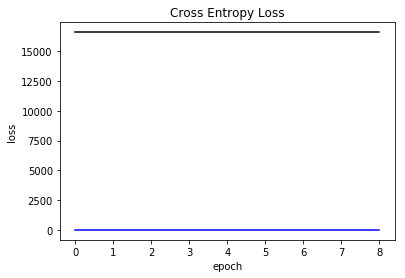

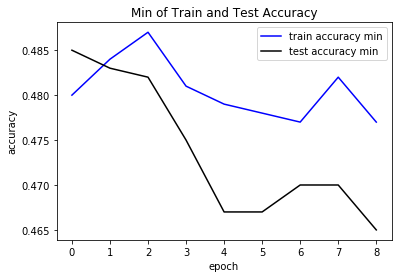

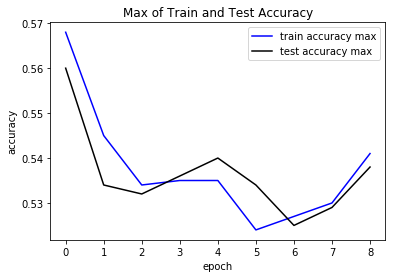

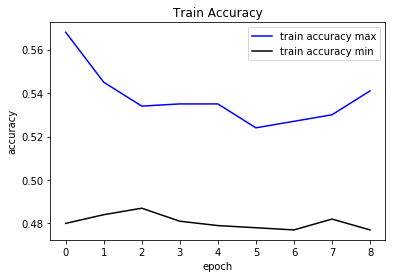

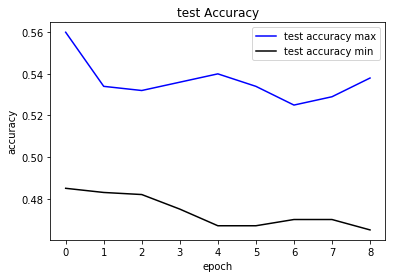

In [164]:
# loss function
plt.plot(loss_trace_min,'b-')
plt.plot(loss_trace_max, 'k-')
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# accuracy min
plt.plot(train_acc_min, 'b-', label='train accuracy min')
plt.plot(test_acc_min, 'k-', label='test accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Min of Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# accuracy max
plt.plot(train_acc_max, 'b-', label='train accuracy max')
plt.plot(test_acc_max, 'k-', label='test accuracy max')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Max of Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# accuracy for train
plt.plot(train_acc_max, 'b-', label='train accuracy max')
plt.plot(train_acc_min, 'k-', label='train accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy')
plt.legend(loc='best')
plt.show()


# accuracy for test
plt.plot(test_acc_max, 'b-', label='test accuracy max')
plt.plot(test_acc_min, 'k-', label='test accuracy min')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('test Accuracy')
plt.legend(loc='best')
plt.show()

In [162]:
print(train_acc_min)
print(train_acc_max)
print(test_acc_min)
print(test_acc_max)

[0.48, 0.484, 0.487, 0.481, 0.479, 0.478, 0.477, 0.482, 0.477]
[0.568, 0.545, 0.534, 0.535, 0.535, 0.524, 0.527, 0.53, 0.541]
[0.485, 0.483, 0.482, 0.475, 0.467, 0.467, 0.47, 0.47, 0.465]
[0.56, 0.534, 0.532, 0.536, 0.54, 0.534, 0.525, 0.529, 0.538]


From above, we can see that the training and test accuracy are kinda low. This method can barely perform as good as a random flip of a fair coin. This is not satisfying. 

# Deep Neural Network

In [11]:
import tensorflow.keras as keras
from keras import models
from keras import layers

#fit the mdoel 
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(150*150*3,)))
network.add(layers.Dense(2, activation='softmax'))
network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
network.fit(sample_training_images, sample_training_labels, epochs=5, batch_size=128)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9163 - accuracy: 0.4620
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6916 - accuracy: 0.5140
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6905 - accuracy: 0.5520
Epoch 4/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6897 - accuracy: 0.5250
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6919 - accuracy: 0.5280


In [13]:
train_loss, train_acc = network.evaluate(sample_training_images, sample_training_labels)
print(train_acc)

1000/1000 [==============================] - 1s 740us/step
0.5070000290870667


In [14]:
test_loss, test_acc = network.evaluate(sample_validation_images, sample_validation_labels)
print(test_acc)

1000/1000 [==============================] - 1s 733us/step
0.49799999594688416


In [15]:
# apparent a single hidden layer model does not work so well; 
batch_size = 128;
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
sample_training_images, sample_training_labels = next(train_data_gen)
sample_validation_images, sample_validation_labels = next(validation_data_gen)
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=128 // batch_size,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=128 // batch_size
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
16/16 [==============================] - 32s 2s/step - loss: 0.8632 - acc: 0.5000 - val_loss: 0.6883 - val_acc: 0.5000
Epoch 2/15
16/16 [==============================] - 32s 2s/step - loss: 0.6808 - acc: 0.5150 - val_loss: 0.6589 - val_acc: 0.6030
Epoch 3/15
16/16 [==============================] - 32s 2s/step - loss: 0.6417 - acc: 0.5965 - val_loss: 0.6137 - val_acc: 0.5825
Epoch 4/15
16/16 [==============================] - 31s 2s/step - loss: 0.5815 - acc: 0.6610 - val_loss: 0.5311 - val_acc: 0.7175
Epoch 5/15
16/16 [==============================] - 31s 2s/step - loss: 0.5272 - acc: 0.7370 - val_loss: 0.4782 - val_acc: 0.7600
Epoch 6/15
16/16 [==============================] - 33s 2s/step - loss: 0.4837 - acc: 0.7515 - val_loss: 0.4369 - val_acc: 0.7720
Epoch 7/15
16/16 [==============================] - 31s 2s/step - loss: 0.4354 - acc: 0.

In [26]:
print(history.history)


{'loss': [0.8670041971206665, 0.6807505035400391, 0.6420758714675904, 0.582484797000885, 0.5243157868385315, 0.4828461074829102, 0.43402662229537964, 0.38418054604530333, 0.34070557403564455, 0.28763164949417114, 0.2479835865497589, 0.19781657767295838, 0.20859829199314117, 0.1513060941696167, 0.1029425145983696], 'acc': [0.5, 0.515, 0.5965, 0.661, 0.737, 0.7515, 0.785, 0.8225, 0.842, 0.8735, 0.8905, 0.9155, 0.909, 0.944, 0.962], 'val_loss': [0.6883179061114788, 0.6588577590882778, 0.6137344390153885, 0.5310823954641819, 0.47819857113063335, 0.4368680715560913, 0.3902442529797554, 0.3441630154848099, 0.29448223020881414, 0.25331011321395636, 0.23382940143346786, 0.2816534247249365, 0.1565401814877987, 0.10591174336150289, 0.08098779106512666], 'val_acc': [0.5, 0.603, 0.5825, 0.7175, 0.76, 0.772, 0.8115, 0.823, 0.8445, 0.8765, 0.926, 0.806, 0.941, 0.9635, 0.984]}


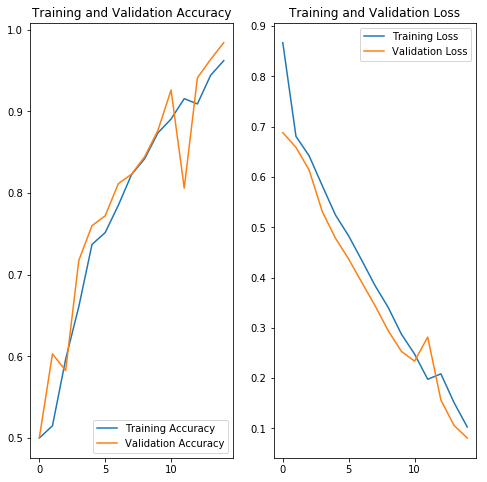

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
print(min(acc))
print(max(acc))

print(min(val_acc))
print(max(val_acc))

0.5
0.962
0.5
0.984


# Summary

For this homework, we used tensorflow to implement (1) Logistic regression on binary outcome; (2) Logistic regression on multinomial outcome; (3) Linear regression; (4) Optimal hyper plane; (5) DNN with single hidden layer, (6) DNN with multiple hidden layers. Then we applied these methods on dogs and cats data set to test both training accuracy and test accuracy. A summary of results can be found below: 

| Methods | Parameters | Training Accuracy (Min--Max) | Test Accuracy (Min--Max) | Other Parameters |
| --- | --- | --- | --- | --- |
| Linear Regression | batch_size = 128 | 0.477--0.594 | 0.483--0.561 | learning_rate = 0.3, iter_num = 3000|
| .. | batch_size = 100 | 0.505--0.607 | 0.492--0.569 | .. |
| .. | batch_size = 200 | 0.573--0.662 | 0.547--0.596 | .. |
| .. | batch_size = 300 | 0.634--0.710 | 0.571--0.619 | .. |
| .. | batch_size = 400 | 0.674--0.747 | 0.588--0.635 | .. |
| .. | batch_size = 500 | 0.707--0.787 | 0.608--0.657 | .. |
| .. | batch_size = 600 | 0.693--0.816 | 0.604--0.672 | .. |
| .. | batch_size = 700 | 0.492--0.847 | 0.498--0.690 | .. |
| Logistic Regression | learning_rate = 0.1 | 0.484--0.590 | 0.500--0.563 | batch_size = 128， iter_num = 3000 |
| .. | learning_rate = 0.2 | 0.571--0.616 | 0.529--0.575 | .. |
| .. | learning_rate = 0.3 | 0.598--0.630 | 0.547--0.583 | .. |
| .. | learning_rate = 0.4 | 0.612--0.642 | 0.557--0.594| .. |
| .. | learning_rate = 0.5 | 0.623--0.650 | 0.566--0.601 | .. |
| .. | learning_rate = 0.6 | 0.632--0.662 | 0.575--0.612 | .. |
| .. | learning_rate = 0.7 | 0.642--0.671 | 0.573--0.621 | .. |
| .. | learning_rate = 0.8 | 0.654--0.676 | 0.583--0.623 | .. |
| .. | learning_rate = 0.9 | 0.660--0.684 | 0.586--0.628 | .. |
| .. | learning_rate = 1.0 | 0.667--0.692 | 0.591--0.626 | .. |
| Optimal Separating Hyperplanes | svmC = 0.1| 0.483--0.577 | 0.488--0.569 | learning_rate = 0.3， batch_size = 128， iter_num = 3000 |
|  .. | svmC = 0.2 | 0.484--0.545 | 0.483--0.534 | .. |
| .. | svmC = 0.3 | 0.487--0.534 | 0.482--0.532 | .. |
| .. | svmC = 0.4 | 0.481--0.535 | 0.479--0.535 | .. |
| .. | svmC = 0.5 | 0.479--0.535 | 0.467--0.540 | .. |
| .. | svmC = 0.6 | 0.478--0.524 | 0.467--0.534 | .. |
| .. | svmC = 0.7 | 0.477--0.527 | 0.470--0.529 | .. |
| .. | svmC = 0.8 | 0.482--0.530 | 0.470--0.529 | .. |
| .. | svmC = 0.9 | 0.477--0.541 | 0.465--0.538 | .. |
| DNN with single hidden layer| Default |0.507 | 0.498 | Default |
| CNN with multiple layers| See model for details |0.5--0.982 | 0.5--0.984 | See model for details |

From the table, we can see that, among all methods, CNN with multiple layers way outperformed the other methods with an maximum of accuracy of 0.982 for training data set and 0.984 for test data set. Other methods have an average accuracy of 0.5 to 0.6, which is slighly better than a random guess. 

From Kaggle website where this question was orignially posted, we listed the top 15 results: 

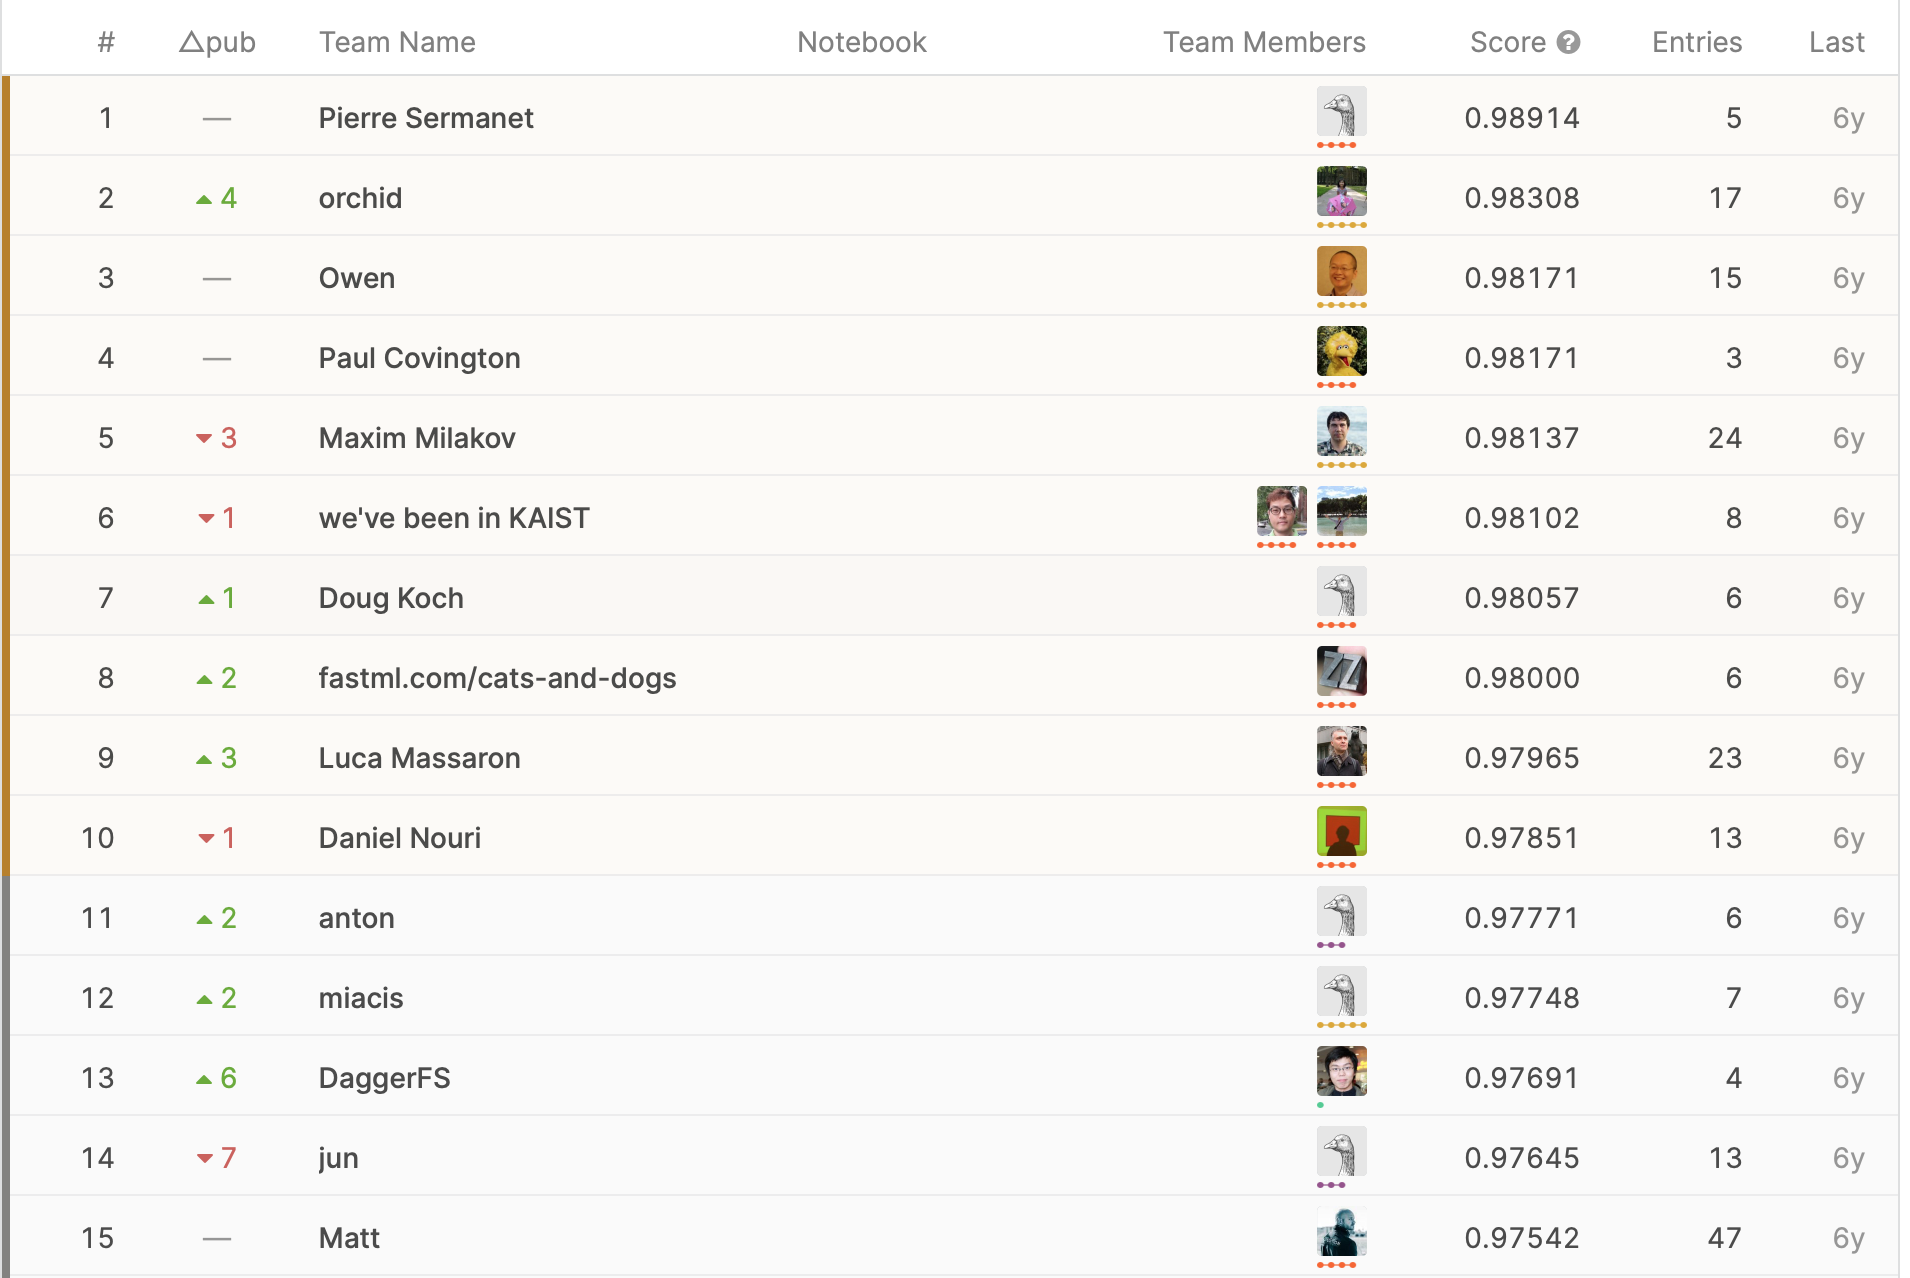

In [29]:
from IPython.display import Image
Image(filename="./Dogs_vs_Cats.png")

Notice that the best results are approximately 0.99. 